In [1]:
import pandas as pd
pd.set_option("display.float_format", "{:.3f}".format)
pd.set_option("display.max_columns", 80)
pd.set_option("display.max_rows", 80)
import numpy as np

# Visualization
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# Modeling & benchmarking
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import shap
from shap.plots import waterfall

# Dealing with imbalanced classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline

# Helper functions
from helper_functions import make_confusion_matrix

In [2]:
df_train = pd.read_csv("../data/processed_training_nov17.csv")
df_train.head(3)

,v2,v3,v5,v6,v7,v10,v13,v14,v1_b,v4_y,v8_t,v9_t,v11_t,v12_p,v12_s,classLabel_yes.
0,-0.632,-0.457,-0.160,-1.448,0.000,-0.167,-0.146,-0.102,0,0,0,1,1,0,0,0
1,-0.691,-0.482,-0.428,-0.075,-0.324,-0.333,0.292,-0.107,1,1,0,0,0,0,1,0
2,0.152,-0.385,0.366,-0.150,-0.389,-0.167,-0.088,-0.089,1,0,0,1,0,0,0,0


In [3]:
df_val = pd.read_csv("../data/processed_validation_nov17.csv")
df_val.head(3)

,v2,v3,v5,v6,v7,v10,v13,v14,v1_b,v4_y,v8_t,v9_t,v11_t,v12_p,v12_s,classLabel_yes.
0,0.163,0.728,0.309,-0.600,0.225,0.000,1.300,-0.009,1,0,1,0,1,0,1,0
1,-0.372,-0.121,-0.779,0.641,-0.209,0.000,-0.120,-0.007,1,0,0,0,1,0,0,0
2,0.413,-0.276,0.611,-0.279,-0.190,0.000,0.400,-0.003,1,1,0,0,0,0,0,0


#### **1.0 Train-test Split**

In [4]:
X_train = df_train.drop('classLabel_yes.', axis='columns')
y_train = df_train['classLabel_yes.']

print(X_train.shape)
print(y_train.shape)

(3700, 15)
(3700,)


In [5]:
X_train.head(3)

,v2,v3,v5,v6,v7,v10,v13,v14,v1_b,v4_y,v8_t,v9_t,v11_t,v12_p,v12_s
0,-0.632,-0.457,-0.160,-1.448,0.000,-0.167,-0.146,-0.102,0,0,0,1,1,0,0
1,-0.691,-0.482,-0.428,-0.075,-0.324,-0.333,0.292,-0.107,1,1,0,0,0,0,1
2,0.152,-0.385,0.366,-0.150,-0.389,-0.167,-0.088,-0.089,1,0,0,1,0,0,0


In [6]:
y_train.head(3)

0    0
1    0
2    0
Name: classLabel_yes., dtype: int64

In [7]:
X_test = df_val.drop('classLabel_yes.', axis='columns')
y_test = df_val['classLabel_yes.']

print(X_test.shape)
print(y_test.shape)

(200, 15)
(200,)


In [8]:
X_test.head(3)

,v2,v3,v5,v6,v7,v10,v13,v14,v1_b,v4_y,v8_t,v9_t,v11_t,v12_p,v12_s
0,0.163,0.728,0.309,-0.600,0.225,0.000,1.300,-0.009,1,0,1,0,1,0,1
1,-0.372,-0.121,-0.779,0.641,-0.209,0.000,-0.120,-0.007,1,0,0,0,1,0,0
2,0.413,-0.276,0.611,-0.279,-0.190,0.000,0.400,-0.003,1,1,0,0,0,0,0


In [9]:
y_test.head(3)

0    0
1    0
2    0
Name: classLabel_yes., dtype: int64

#### **2.0 Baseline Logistic Regression**

We'll start off by training a simple Logistic Regression model. We'll use GridSearchCV for hyperparameter tuning, to select the best set of hyperparameters for a machine learning model. 

For the `scoring` parameter in GridSearchCV, we'll go with the *f1-score*. The *f1-score* takes both precision and recall into account. Precision measures the ability of the model to correctly identify positive samples, while recall measures the ability to find all positive samples. In imbalanced datasets, where the positive class dominates in this case, accuracy can be misleading because a classifier that always predicts the majority class can have a high accuracy. Hence, the *f1-score* provides a more balanced measure of performance that considers false positives and false negatives.

Cross-validation is also used to estimate how well a model will perform on unseen data by splitting the dataset into multiple subsets (folds) for training and testing. This is done via `StratifiedKFold()`.

In [10]:
scoring = ['f1']

stratified_kfold = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [14]:
pipeline = imbpipeline(steps = [['classifier', LogisticRegression(random_state=42, max_iter=4000)]])

param_grid = {
    'classifier__penalty': ['l1','l2'],
    'classifier__C': [100, 10, 1.0, 0.1, 0.01],
    'classifier__solver': ['liblinear', 'saga'],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    cv=stratified_kfold,
    refit='f1',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}\nBest Hyperparameters: {grid_search.best_params_}')

Cross-validation score: 0.9791299178737916
Test score: 0.6863468634686347
Best Hyperparameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


In [15]:
y_pred = grid_search.predict(X_test)
cm_gd = confusion_matrix(y_test, y_pred)

For the cross-validation score, **the model achieved a near perfect F1-score of 0.98 during cross-validation**. However, the test score (*f1-score*) on the test dataset is relatively low at 0.69. This is significantly lower than the cross-validation score, indicates **overfitting on the training data** and suggests that **the model may not generalize as well to unseen data as it did during training**. 

Overfitting can perhaps be explained by the relatively small dataset. The model may overfit because it doesn't have enough examples to learn the true underlying patterns. More data can often help reduce overfitting.

At the moment, it has low precision for the positive class, and extremely poor recall for the negative class. The model tends to predict the positive class more easily. We will aim to reduce the number of False Positives later on.

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.21      0.34       107
           1       0.52      1.00      0.69        93

    accuracy                           0.57       200
   macro avg       0.76      0.60      0.51       200
weighted avg       0.78      0.57      0.50       200



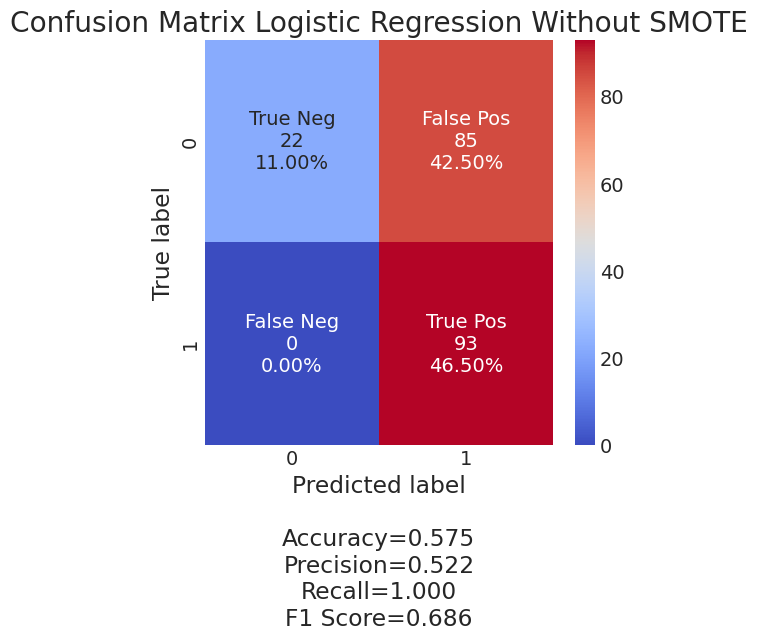

In [17]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(
    cm_gd, 
    group_names=labels,
    categories=categories, 
    cmap='coolwarm',
    figsize=(5,5),
    title="Confusion Matrix Logistic Regression Without SMOTE"
)

#### **3.0 Logistic Regression with SMOTE and Random Undersampling**

For our second approach, we'll use SMOTE and Random Undersampling. 

SMOTE is used to mitigate class imbalance by oversampling the minority class by generating synthetic samples. When one class is underrepresented, traditional machine learning algorithms can have a bias towards the majority class, leading to poor performance on the minority class. In our code, `sampling_strategy=0.2` means that the number of minority class samples will be increased to be 20% of the majority class samples.

After SMOTE, RandomUnderSampler randomly selects a subset of the majority class which, in effect, "reduces" the size of the majority class. In our code, `sampling_strategy=0.6` means that the minority class is now 60% of the majority class (instead of just 20% after SMOTE). Therefore, had we choson that X=1, you will have a result similar to *auto* which makes the two classes 100% balanced.

Future explorations can benefit by specifying different SMOTE/RandomUnderSampling combinations or utilizing only one technique (instead of both).

In [31]:
# Define the SMOTE and RandomUnderSampler objects
smote = SMOTE(random_state=11, sampling_strategy=0.2)
random_undersampler = RandomUnderSampler(
    random_state=11,
    sampling_strategy=0.60
)

In [32]:
pipeline2 = imbpipeline(steps = [
    ['smote', smote],
    ['random_undersampling', random_undersampler],
    ['classifier', LogisticRegression(random_state=42,max_iter=4500)],
])
    
param_grid2 = {
    'classifier__penalty': ['l1','l2'],
    'classifier__C': [100, 10, 1.0, 0.1, 0.01],
    'classifier__solver': ['liblinear', 'saga'],
}

grid_search2 = GridSearchCV(
    estimator=pipeline2,
    param_grid=param_grid2,
    scoring=scoring,
    cv=stratified_kfold,
    refit='f1',
    n_jobs=-1
)

grid_search2.fit(X_train, y_train)
cv_score2 = grid_search2.best_score_
test_score2 = grid_search2.score(X_test, y_test)
print(f'Cross-validation score: {cv_score2}\nTest score: {test_score2}\nBest Hyperparameters: {grid_search2.best_params_}')

Cross-validation score: 0.9678730247238123
Test score: 0.7829787234042553
Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


In [40]:
y_pred2 = grid_search2.predict(X_test)
cm_gd2 = confusion_matrix(y_test, y_pred2)

Overall, this time we see general improvements in recall for the negative class and precision for the positive class. The **overall *f1-score* has also increased**. The number of False Postives have also reduced by quite a bit, while still maintaining extremely good recall for the positive class, and precision for the negative class (~1.00).

In [42]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.98      0.53      0.69       107
           1       0.65      0.99      0.78        93

    accuracy                           0.74       200
   macro avg       0.82      0.76      0.74       200
weighted avg       0.83      0.74      0.73       200



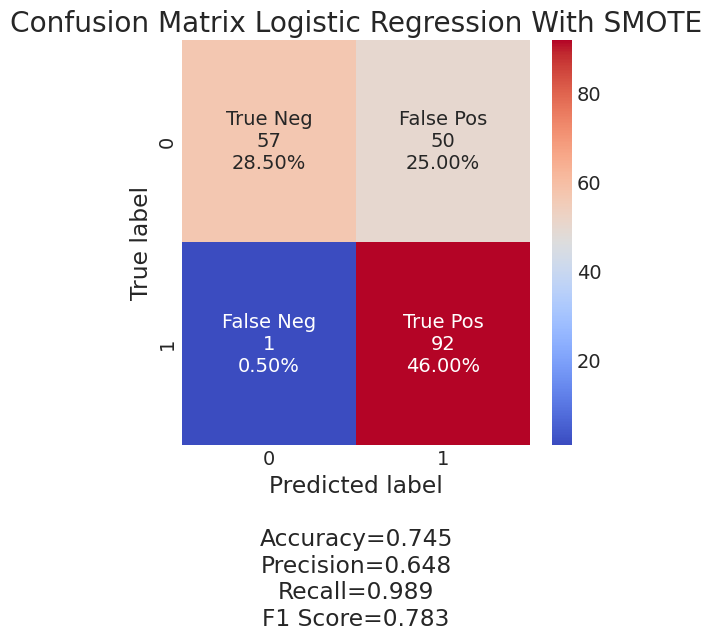

In [43]:
make_confusion_matrix(
    cm_gd2,
    group_names=labels,
    categories=categories, 
    cmap='coolwarm',
    figsize=(5,5),
    title="Confusion Matrix Logistic Regression With SMOTE"
)

#### **4.0 Analysis & Recommendations**

Overall, while there's an extremely high cross-validation score, the model relatively poor on the test set, resulting in bad generalisability. We make several suggestions & hypotheses:

- We recommend updates on the dataset with **more instances of the *no.* class for the target**, `classLabel` **in the training set**. The bad generalisability is perhaps due to not enough learning examples from the minority class & overfitting on the training set.
- Since we do not know the nature of each feature column, perhaps there **may have been a proxy feature that is directly or indirectly derived from the target column in the training set, leading to data leakage**. This can potentially explain it's extremely good performance on the training set. This would have certainly been the case if we included `v17`.
- The **training set, which only has 3,700 rows, is extremely small**. A larger dataset can increase the odds of capturing more accurate distributions of the data.
- **Different SMOTE/Random under sampling parameters** can also be used in the future.
- Better data quality such as **less missing values** can also help improve the model.
- **Feature engineering work** also ought to be done to get better predictors.
- Finally, **different ML models** such as gradient boosting/neural networks can also be experimented with to see if they yield better performance. XGBoost, in particular, is robust to missing values which is a good candidate for the next experiment.

#### **5.0 Feature Importance using SHAP**

SHAP (SHapley Additive exPlanations) values provide a way to attribute the prediction of a machine learning model to individual input features or variables, helping to understand the contributions of each feature to the model's output.

SHAP values represent how much each feature contributes to the model's prediction for each data point. Positive SHAP values indicate that the feature contributes positively to the prediction, while negative SHAP values indicate a negative contribution. The `shap_values` **object below contains the SHAP values for each instance in the combined dataset**, indicating the contribution of each feature to the model's predictions for that instance.

However, on the whole, **feature importance plots using SHAP are difficult to interpret with such imbalanced data**.

*Personal Notes:* https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html

In [44]:
model = grid_search2.best_estimator_
explainer = shap.Explainer(model.predict, X_train)

# generate SHAP values from a combination of test and training data
shap_values = explainer(pd.concat([X_test, X_train]))

PermutationExplainer explainer: 3901it [01:36, 36.74it/s]                          


From the below, we can say that `v8_t`, `v6`, `v14` and `v10` have the largest sway over model output, followed by tenuous contributions from the other features.

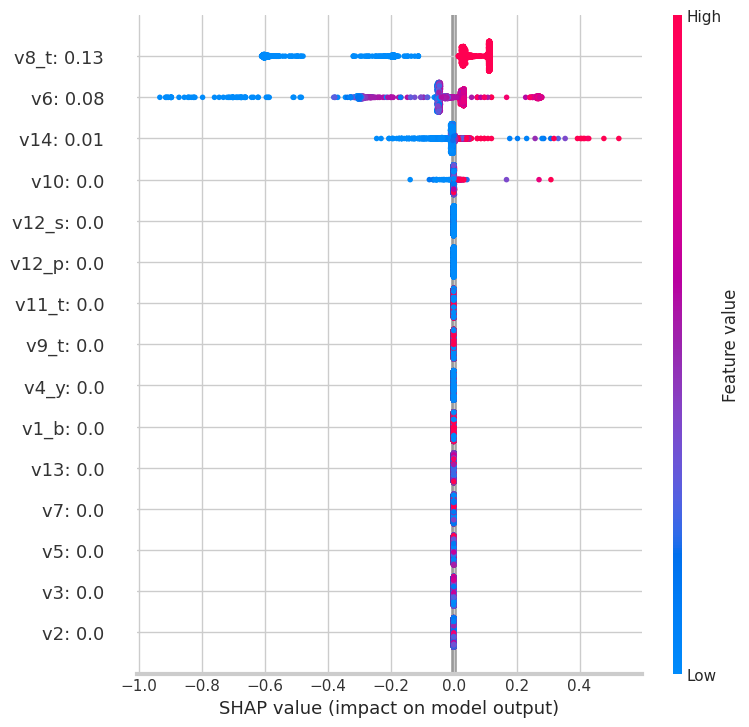

In [45]:
X = pd.concat([X_test, X_train])

# Note: https://stackoverflow.com/questions/72087719/shap-summary-plot-and-mean-values-displaying-together
feature_names = [
    a + ": " + str(b) for a,b in zip(X.columns, np.abs(shap_values.values).mean(0).round(2))
]

# Generate summary plot of feature importance
shap.summary_plot(shap_values, X, max_display=X.shape[1], 
                  feature_names=feature_names)

The 2 waterfall charts below show the features that were most important for a single example in the dataset and in this case it shows that `v8_t`, `v6` and `v14` were the most influential feature for the first 2 SHAP values. We note that this **may not the case for the rest of the dataset**, just these 2 examples.

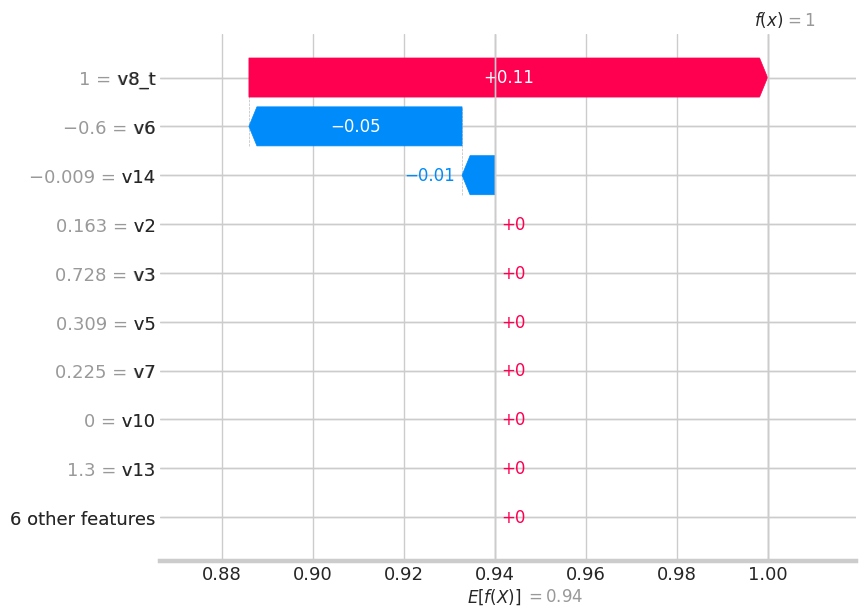

In [46]:
# waterfall chart 1
shap.plots.waterfall(shap_values[0])

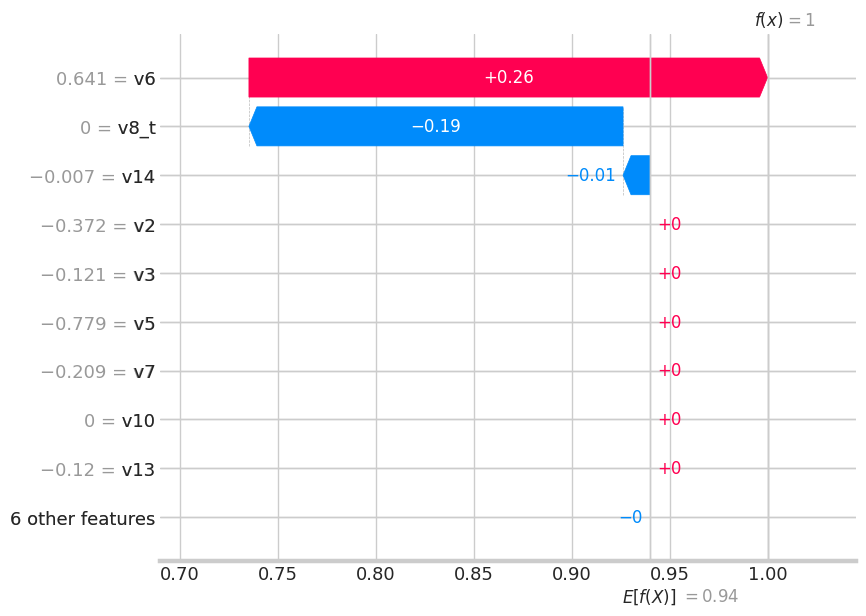

In [47]:
# waterfall chart 2
shap.plots.waterfall(shap_values[1])


The scatter plots below visualize the relationship between feature values and their corresponding SHAP values for a specific instance or set of instances. We aim to look at the top 4 features identified in the summary plot above.

For `v8_t`, it is a slightly positive predictor of `classLabel` when `v8_t=1` , and a negative predictor otherwise.

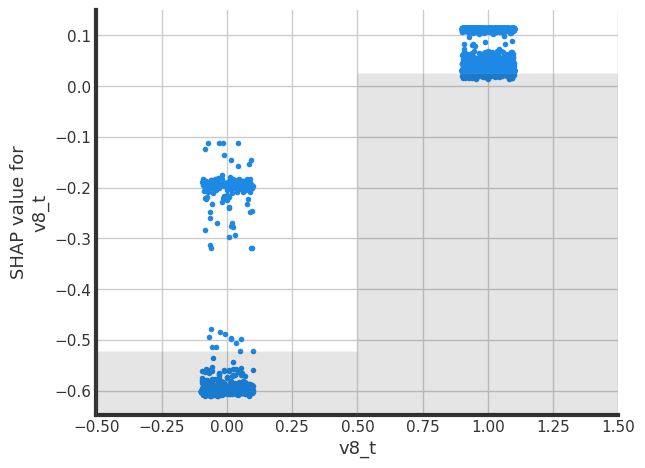

In [51]:
shap.plots.scatter(shap_values[:,"v8_t"])

For `v6`, `v6 < 0` negatively influences `classLabel`, and very slightly positively influences `classLabel` when `v6 > 0`.

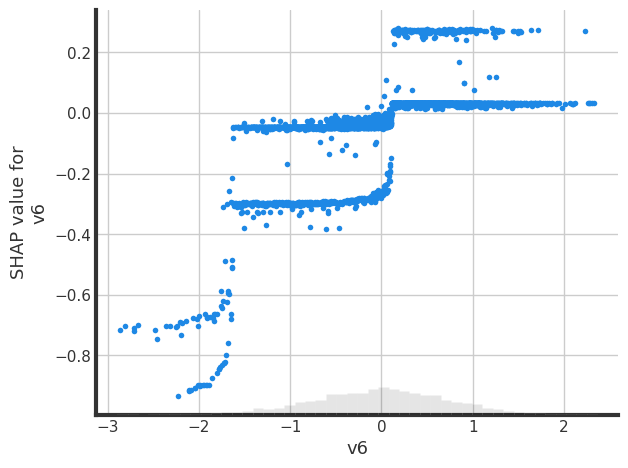

In [50]:
shap.plots.scatter(shap_values[:,"v6"])

Most of the values in `v10` also have very little impact except when the values are centered around 0 which result in a mostly negative impact on `classLabel`. This changes to a positive impact when `v10 > 80`.

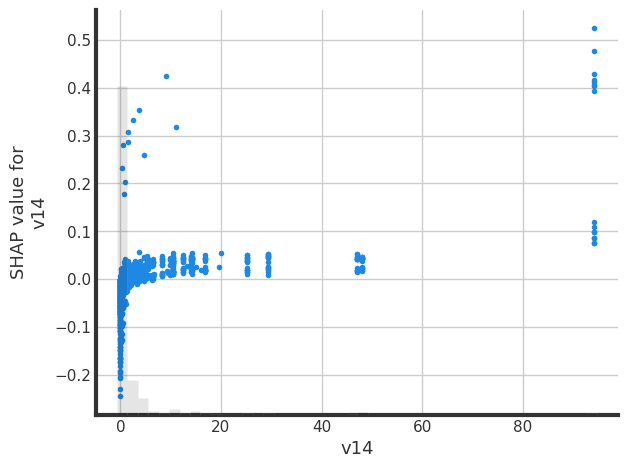

In [49]:
shap.plots.scatter(shap_values[:,"v14"])

Most of the values in `v10` also have no impact except when the values are centered around less than 0 which result in a negative impact on `classLabel`.

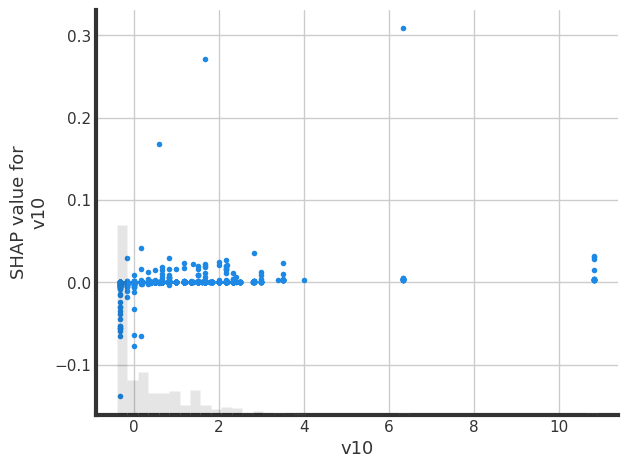

In [48]:
shap.plots.scatter(shap_values[:,"v10"])